## 概要
使用xresnet50, 在小数据集上进行图像分类的训练. 关键的技术:

* 在小数据集上训练
* 对图像按照进行规一化. 可以计算整个数据集的mean, std. 也可以根据每个batch进行归一化.
* 先在小(分辨率)图上进行训练, 再在大分辨率图上进行fine_tune可以提高训练效率.


## Init fast ai

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.all import *

Mounted at /content/gdrive


## Data

In [ ]:
path = untar_data(URLs.IMAGENETTE)

### Check The Data

In [ ]:
path.ls().sorted()

(#3) [Path('/root/.fastai/data/imagenette2/noisy_imagenette.csv'),Path('/root/.fastai/data/imagenette2/train'),Path('/root/.fastai/data/imagenette2/val')]

In [ ]:
df = pd.read_csv(path/'noisy_imagenette.csv')
df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


## Base Line

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
          get_items=get_image_files,
          get_y=parent_label,
          item_tfms=Resize(460), # for every item, maybe random crop here
          batch_tfms=aug_transforms(size=224, min_scale=0.75) # for each batch
) 
dls = dblock.dataloaders(path, bs=64)

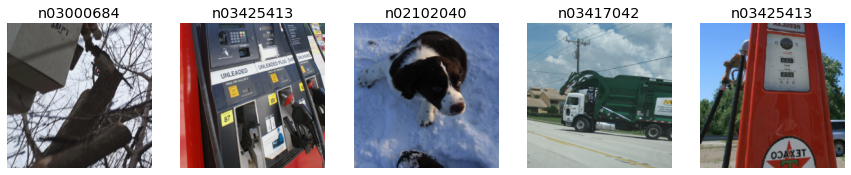

In [ ]:
dls.train.show_batch(max_n=5, nrows=1)

In [ ]:
# xresnet: (2019,CVPR)Bag of Tricks for Image Classification with Convolutional Neural Networks
# ref: https://zhuanlan.zhihu.com/p/190241924
model = xresnet50(n_out=dls.c) # dls.c number of category, by default pretrained=false
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
# schedules the learning rate with a cosine annealing according to:  Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates
learn.fit_one_cycle(5, 3e-3) # train 5 epoch with maxlr=3e-3

epoch,train_loss,valid_loss,accuracy,time
0,1.559408,3.083885,0.348394,00:35
1,1.251792,2.240346,0.483196,00:31
2,0.972176,1.014733,0.682599,00:31
3,0.741096,0.740750,0.778566,00:31
4,0.609907,0.552101,0.827110,00:31


## Normalization
将图片进行归一化mean=0, std=1. 需要注意的是, __必须保证模型训练和使用时具有相同的归一化__.

In [ ]:
x,y = dls.one_batch()
x.shape, x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(torch.Size([64, 3, 224, 224]),
 TensorImage([0.4681, 0.4626, 0.4213], device='cuda:0'),
 TensorImage([0.2858, 0.2756, 0.3000], device='cuda:0'))

DataBlock定义了数据如何进行解析. 默认是train=80% valid-20%.

item_tfms（在cpu上, 先执行）和 batch_tfms(在GPU上, 后执行)

参考https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/01_Slides.pdf

In [ ]:
def get_dls(bs, size):
  dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    get_y=parent_label,
                    item_tfms=Resize(460), # maybe add RandomResizedCrop
                    batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                                Normalize.from_stats(*imagenet_stats)] # normalize data using specified mean and std
                    )
  dls = dblock.dataloaders(path, bs=bs)
  #len(dls.train), len(dls.valid)
  return dls

In [ ]:
dls = get_dls(64, 224)
# reset model, train using normalized image data
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
# fine_tune refer to fastbook ch5 ch1
# lr find refer to fastbook ch5
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.584299,1.781370,0.471247,00:31
1,1.269434,1.642491,0.506721,00:32
2,0.964990,1.050541,0.677745,00:32
3,0.737913,0.648659,0.796117,00:31
4,0.608418,0.554932,0.825616,00:31


## Progressive Resizing
神经网络学习到的很多特征与图片的分辨率无关. 先在小(分辨率)图上训练, 再在大图上训练(fine_tune), 可以很好地提高训练效率. 与transfer learning思想一致.

start training using small images, and end training using large images.

As we have seen, the kinds of features that are learned by convolutional neural networks are not in any way specific to the size of the image—early layers find things like edges and gradients, and later layers may find things like noses and sunsets.

But clearly there are some differences between small images and big ones, so we shouldn't expect our model to continue working exactly as well, with no changes at all. Does this remind you of something? When we developed this idea, it reminded us of transfer learning! We are trying to get our model to learn to do something a little bit different from what it has learned to do before. Therefore, we should be able to use the fine_tune method after we resize our images.

SuggestedLRs(valley=0.00013182566908653826)

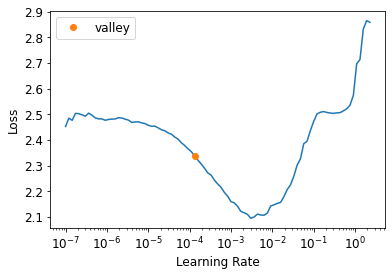

In [ ]:
dls = get_dls(128, 128)
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.lr_find()

In [ ]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.580932,1.760531,0.517550,00:26
1,1.234577,1.020632,0.678865,00:26
2,0.941964,0.837141,0.720687,00:25
3,0.735540,0.627022,0.796490,00:26


使用大图训练, 这个地方有个疑问, 网络结构一般都被设计好了的, 输入图片分辨率应该是不能变才是?

 __动态尺寸模型__.
Progressive Resizing requires that the network architecture be capable of handling different sized images.

refer to: https://docs.mosaicml.com/en/v0.12.0/method_cards/progressive_resizing.html

对于像我们设计的网络, 其实其参数由kernel和feature size决定, 与input image size无关, image size相关的在于最后输出, 需要做一个adaptive pooling统一到同一维度.

SuggestedLRs(valley=0.0002290867705596611)

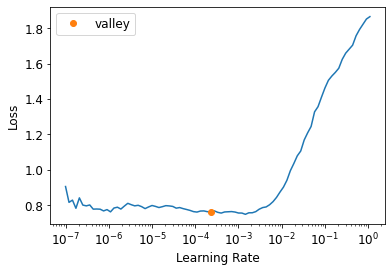

In [ ]:
learn.dls = get_dls(64,224)
learn.lr_find()

In [ ]:
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.828838,1.454080,0.587379,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.642121,0.676066,0.784541,00:32
1,0.650641,0.691641,0.781553,00:32
2,0.571524,0.553635,0.819268,00:31
3,0.488138,0.455337,0.857356,00:31
4,0.434351,0.431756,0.864451,00:31
